What we need:
* Refine efficiency measure
* Develop null models (for all layers or just monoplex?)
* Create visualization

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import re
import networkx as nx
import ggplot
import matplotlib.pyplot as plt
import random
from geopy.distance import great_circle, vincenty
from haversine import haversine
import itertools
import random
import time
import collections
import powerlaw
%matplotlib inline

C:\Users\Owner\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Owner\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#API Call
url = "http://realtime.mbta.com/developer/api/v2/routes"

querystring = {"api_key":"cgb4DBBwS0GKb7HM4y05bA","format":"json"}

headers = {
    'cache-control': "no-cache",
    'postman-token': "4c7b8b89-58b4-c8f5-2509-0647e1775340"
    }

response = requests.request("GET", url, headers=headers, params=querystring)
routes=response.json()
#Route Types: Subway, Commuter Rail, Bus

#Separation of Types of Route
subwayRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Subway']
subwayRouteID=[y for x in subwayRouteID for y in x]
crRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Commuter Rail']
crRouteID=[y for x in crRouteID for y in x]
busRouteID=[[y['route_id'] for y in x['route']] for x in routes['mode'] if x['mode_name']=='Bus']
busRouteID=[y for x in busRouteID for y in x]


routesDic={'Subway':{subkey:[] for subkey in subwayRouteID},'Bus':{buskey:[] for buskey in busRouteID},'Commuter Rail':{crkey:[] for crkey in crRouteID}}

#get the stops for each route

for key in routesDic:
    for route in routesDic[key]:
        url = "http://realtime.mbta.com/developer/api/v2/stopsbyroute"
        querystring = {"api_key":"cgb4DBBwS0GKb7HM4y05bA","route":route,"format":"json"}
        headers = {
            'cache-control': "no-cache",
            'postman-token': "014e80a3-7552-8a15-6796-afa8e81495f3"
            }
        response = requests.request("GET", url, headers=headers, params=querystring)
        stops=response.json()
        routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x['stop_name']).replace(' Busway','').replace(' Lower','').replace(' Upper','')+'_{0}'.format(route),(float(x['stop_lon']),float(x['stop_lat']))] for x in stops['direction'][0]['stop']]
        if key=='Subway':
            routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x[0]).replace(' Orange Line',''),x[1]] for x in routesDic[key][route]]
        else:
            routesDic[key][route]=[[re.sub(r'(.*) - .*',r'\1',x[0]).replace(' Station',''),x[1]] for x in routesDic[key][route] if 'South' not in x and 'North' not in x]

#separate Ashmont and Braintree lines
routesDic['Subway']['Red-Ashmont']=routesDic['Subway']['Red'][:15]+routesDic['Subway']['Red'][16:21]
routesDic['Subway']['Red-Braintree']=routesDic['Subway']['Red'][:16]+routesDic['Subway']['Red'][21:-1]
routesDic['Subway']['Red-Ashmont'][-5][0]='JFK/UMASS_Red-Ashmont'
routesDic['Subway']['Red-Braintree'][-12][0]='JFK/UMASS_Red-Braintree'
del routesDic['Subway']['Red']



In [3]:
#create adjacency lists for each stop with lat, long data
subwayStops=[routesDic['Subway'][key] for key in routesDic['Subway']]
subwayStops=np.unique([y[0] for x in subwayStops for y in x])
subwayAdjacencyList={key:[] for key in subwayStops}
for route in routesDic['Subway']:
    for i in range(len(routesDic['Subway'][route])):
        if i==0:
            if routesDic['Subway'][route][i+1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i+1])
        elif i>0 and i<(len(routesDic['Subway'][route])-2):
            if routesDic['Subway'][route][i-1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i-1])
            if routesDic['Subway'][route][i+1] not in subwayAdjacencyList[routesDic['Subway'][route][i][0]]:
                subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i+1])
        else:
            subwayAdjacencyList[routesDic['Subway'][route][i][0]].append(routesDic['Subway'][route][i-1])
            subwayAdjacencyList[routesDic['Subway'][route][i-1][0]].append(routesDic['Subway'][route][i])
subwayAdjacencyList

{'Airport_Blue': [['Wood Island_Blue', (-71.02286539, 42.3796403)],
  ['Maverick_Blue', (-71.03952958, 42.36911856)]],
 'Alewife_Red': [['Davis_Red', (-71.121815, 42.39674)]],
 'Allston Street_Green-B': [['Griggs Street_Green-B', (-71.134949, 42.348545)],
  ['Warren Street_Green-B', (-71.140457, 42.348343)]],
 'Andrew_Red': [['Broadway_Red', (-71.056967, 42.342622)],
  ['JFK/UMASS_Red-Ashmont', (-71.052391, 42.320685)],
  ['JFK/UMASS_Red-Braintree', (-71.052391, 42.320685)]],
 'Aquarium_Blue': [['Maverick_Blue', (-71.03952958, 42.36911856)],
  ['State Street_Blue', (-71.057598, 42.358978)]],
 'Arlington_Green-B': [['Boylston_Green-B', (-71.06459, 42.35302)],
  ['Copley_Green-B', (-71.077447, 42.349974)]],
 'Arlington_Green-C': [['Boylston_Green-C', (-71.06459, 42.35302)],
  ['Copley_Green-C', (-71.077447, 42.349974)]],
 'Arlington_Green-D': [['Boylston_Green-D', (-71.06459, 42.35302)],
  ['Copley_Green-D', (-71.077447, 42.349974)]],
 'Arlington_Green-E': [['Boylston_Green-E', (-71.0645

In [4]:
#create adjacency list for bus
busStops=[routesDic['Bus'][key] for key in routesDic['Bus']]
busStops=np.unique([y[0] for x in busStops for y in x])
busAdjacencyList={key:[] for key in busStops}
for route in routesDic['Bus']:
    for i in range(len(routesDic['Bus'][route])):
        if i==0:
            if routesDic['Bus'][route][i+1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i+1])
        elif i>0 and i<(len(routesDic['Bus'][route])-2):
            if routesDic['Bus'][route][i-1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i-1])
            if routesDic['Bus'][route][i+1] not in busAdjacencyList[routesDic['Bus'][route][i][0]]:
                busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i+1])
        else:
            busAdjacencyList[routesDic['Bus'][route][i][0]].append(routesDic['Bus'][route][i-1])
            busAdjacencyList[routesDic['Bus'][route][i-1][0]].append(routesDic['Bus'][route][i])
busAdjacencyList

{' Franklin St @ Washington St_236': [['Pearl St @ Washington St_236',
   (-71.004953, 42.202279)],
  ['Franklin St @ Summer St_236', (-71.007714, 42.203136)]],
 '10 Centennial Drive_436': [['Centennial Dr opp Rt128 Ramp_436',
   (-70.953009, 42.524442)],
  ['10 Centennial Drive_436', (-70.954649, 42.526993)],
  ['10 Centennial Drive_436', (-70.951632, 42.526045)],
  ['Essex Ctr Dr @ Essex Green Dr_436', (-70.950098, 42.539617)]],
 '100 Mutton Lane_222': [['Mutton Lane @ Old Stone Way_222',
   (-70.925524, 42.199225)],
  ['1197 Washington St_222', (-70.927982, 42.196419)]],
 '1002 S Franklin St_230': [['S Franklin St @ Upland St_230',
   (-71.011692, 42.125597)],
  ['S Franklin St @ Hamilton Way_230', (-71.014033, 42.12247)]],
 '101 Anawan Ave opp Allenwood St_38': [['Anawan Ave @ W Roxbury Pkwy_38',
   (-71.147859, 42.284898)],
  ['Park St @ Gilmore Terr_38', (-71.150507, 42.282011)]],
 '1010 Massachusetts Ave opp Magazine St_708': [['Andrew_708',
   (-71.057655, 42.330154)],
  ['Alba

In [5]:
#create adjacency list for commuter rail
crStops=[routesDic['Commuter Rail'][key] for key in routesDic['Commuter Rail']]
crStops=np.unique([y[0] for x in crStops for y in x])
crAdjacencyList={key:[] for key in crStops}
for route in routesDic['Commuter Rail']:
    for i in range(len(routesDic['Commuter Rail'][route])):
        if i==0:
            if routesDic['Commuter Rail'][route][i+1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i+1])
        elif i>0 and i<(len(routesDic['Commuter Rail'][route])-2):
            if routesDic['Commuter Rail'][route][i-1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i-1])
            if routesDic['Commuter Rail'][route][i+1] not in crAdjacencyList[routesDic['Commuter Rail'][route][i][0]]:
                crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i+1])
        else:
            crAdjacencyList[routesDic['Commuter Rail'][route][i][0]].append(routesDic['Commuter Rail'][route][i-1])
            crAdjacencyList[routesDic['Commuter Rail'][route][i-1][0]].append(routesDic['Commuter Rail'][route][i])

#North Station and South Station got turned into North and South
#find all instances of South_CR or North_CR and store them
southStation=[x for x in crAdjacencyList if re.search('South_CR-.*',x)]
northStation=[x for x in crAdjacencyList if re.search('North_CR-.*',x)]

#Naively change the adjacency list such that all instances of North_CR are North Station_CR
for stop in crAdjacencyList:
    if stop in northStation:
        crAdjacencyList['North Station'+re.search('.*(-.*)',stop).group(1)]=crAdjacencyList[stop]
        del crAdjacencyList[stop]
    elif stop in southStation:
        crAdjacencyList['South Station'+re.search('.*(-.*)',stop).group(1)]=crAdjacencyList[stop]
        del crAdjacencyList[stop]
for stop in crAdjacencyList:
    for i in range(len(crAdjacencyList[stop])):
        if crAdjacencyList[stop][i][0] in northStation:
            crAdjacencyList[stop][i][0]='North Station'+re.search('.*(-.*)',stop).group(1)
        elif crAdjacencyList[stop][i][0] in southStation:
            crAdjacencyList[stop][i][0]='South Station'+re.search('.*(-.*)',stop).group(1)
crAdjacencyList

{'Abington_CR-Kingston': [['South Weymouth_CR-Kingston',
   (-70.953302, 42.155025)],
  ['Whitman_CR-Kingston', (-70.923411, 42.082749)]],
 'Anderson/Woburn_CR-Haverhill': [['Melrose Highlands_CR-Haverhill',
   (-71.068297, 42.469464)],
  ['Greenwood_CR-Haverhill', (-71.067247, 42.483005)]],
 'Anderson/Woburn_CR-Lowell': [['Mishawum_CR-Lowell', (-71.137618, 42.504402)],
  ['Wilmington_CR-Lowell', (-71.174334, 42.546624)]],
 'Andover_CR-Haverhill': [['Ballardvale_CR-Haverhill',
   (-71.159962, 42.627356)],
  ['Lawrence_CR-Haverhill', (-71.15198, 42.701806)]],
 'Ashland_CR-Worcester': [['Framingham_CR-Worcester', (-71.416792, 42.276719)],
  ['Southborough_CR-Worcester', (-71.524371, 42.267024)]],
 'Attleboro_CR-Providence': [['Stoughton_CR-Providence',
   (-71.103627, 42.124084)],
  ['South Attleboro_CR-Providence', (-71.354621, 41.897943)]],
 'Auburndale_CR-Worcester': [['West Newton_CR-Worcester',
   (-71.230528, 42.347878)],
  ['Wellesley Farms_CR-Worcester', (-71.272288, 42.323608)]]

In [6]:
#create a list of stops with lat, long data
subwayStopLoc={key[0]:key[1] for key in [y for x in subwayAdjacencyList.values() for y in x]}
busStopLoc={key[0]:key[1] for key in [y for x in busAdjacencyList.values() for y in x]}
crStopLoc={key[0]:key[1] for key in [y for x in crAdjacencyList.values() for y in x]}
subwayStopLoc

{'Airport_Blue': (-71.030395, 42.374262),
 'Alewife_Red': (-71.142483, 42.395428),
 'Allston Street_Green-B': (-71.137955, 42.348701),
 'Andrew_Red': (-71.057655, 42.330154),
 'Aquarium_Blue': (-71.051652, 42.359784),
 'Arlington_Green-B': (-71.070893, 42.351902),
 'Arlington_Green-C': (-71.070893, 42.351902),
 'Arlington_Green-D': (-71.070893, 42.351902),
 'Arlington_Green-E': (-71.070893, 42.351902),
 'Ashmont_Mattapan': (-71.064489, 42.284652),
 'Ashmont_Red': (-71.064489, 42.284652),
 'Assembly_Orange': (-71.077257, 42.392811),
 'Babcock Street_Green-B': (-71.12165, 42.35182),
 'Back Bay_Orange': (-71.075727, 42.34735),
 'Back of the Hill_Green-E': (-71.111313, 42.330139),
 'Beachmont_Blue': (-70.99231944, 42.39754234),
 'Beaconsfield_Green-D': (-71.140823, 42.335846),
 'Beale St @ Greenwood Ave_Red': (-71.018064, 42.26656),
 'Blandford Street_Green-B': (-71.100258, 42.349293),
 'Boston College_Green-B': (-71.166769, 42.340081),
 'Boston Univ Central_Green-B': (-71.106865, 42.35008

In [7]:
def euclidean_distance(u,v):
    return np.sqrt((u[0]-v[0])**2+(u[1]-v[1])**2)


In [8]:
G=nx.Graph()
for stop in subwayStopLoc:
    G.add_node(stop,Subway=True,loc=subwayStopLoc[stop])
for stop in subwayAdjacencyList:
    for i in range(len(subwayAdjacencyList[stop])): 
        if G.has_edge(stop,subwayAdjacencyList[stop][i][0]) and 'Subway' in G[stop][subwayAdjacencyList[stop][i][0]]:
            continue
        else:
            G.add_edge(stop,subwayAdjacencyList[stop][i][0],Subway=True,Distance=euclidean_distance(subwayStopLoc[stop],subwayAdjacencyList[stop][i][1]))
for stop in busStopLoc:
    if stop in G:
        G.node[stop]['Bus']=True
    else:
        G.add_node(stop,Bus=True,loc=busStopLoc[stop])
for stop in busAdjacencyList:
    for i in range(len(busAdjacencyList[stop])):
        if G.has_edge(stop,busAdjacencyList[stop][i][0]) and 'Bus' in G[stop][busAdjacencyList[stop][i][0]]:
            continue
        else:
            G.add_edge(stop,busAdjacencyList[stop][i][0],Bus=True,Distance=euclidean_distance(busStopLoc[stop],busAdjacencyList[stop][i][1]))
for stop in crStopLoc:
    if stop in G:
        G.node[stop]['Commuter_Rail']=True
    else:
        G.add_node(stop,Commuter_Rail=True,loc=crStopLoc[stop])
for stop in crAdjacencyList:
        for i in range(len(crAdjacencyList[stop])):
            if G.has_edge(stop,crAdjacencyList[stop][i][0]) and 'Commuter_Rail' in G[stop][crAdjacencyList[stop][i][0]]:
                continue
            else:
                G.add_edge(stop,crAdjacencyList[stop][i][0],Commuter_Rail=True,Distance=euclidean_distance(crStopLoc[stop],crAdjacencyList[stop][i][1])) 

sameNodes={node:None for node in G.nodes()} #create a dictionary of keys as stops and vals set to None
nodes=list(sameNodes)#the copy of these nodes will be used as look up
for node in nodes:
    if node not in sameNodes:
        continue
    isoNodes=[x for x in G.nodes() if x!=node and G.nodes()[x]['loc']==G.nodes()[node]['loc']]#created a list isoNodes to find nodes wit the same location that aren't the same.
    for isonode in isoNodes:
        del sameNodes[isonode]#delete the instance of this stop because we already accounted for it
    sameNodes[node]=isoNodes

sameNodes={x:sameNodes[x] for x in sameNodes if len(sameNodes[x])>0}

for node in sameNodes:
    for node_1 in sameNodes[node]:
        try:
            G=nx.contracted_nodes(G,node,node_1)#contract the nodes s.t. these two nodes are now one
        except:
            print(node,node_1)

G.remove_edges_from(list(nx.selfloop_edges(G)))

nx.write_gpickle(G, "MBTA.gpickle")

In [9]:
#creates the subway layer of the MBTA
subwayGraph=nx.Graph()
for stop in subwayStopLoc:
    subwayGraph.add_node(stop,Subway=True,loc=subwayStopLoc[stop])
for stop in subwayAdjacencyList:
    for i in range(len(subwayAdjacencyList[stop])): 
            subwayGraph.add_edge(stop,subwayAdjacencyList[stop][i][0],Distance=euclidean_distance(subwayStopLoc[stop],subwayAdjacencyList[stop][i][1]))

sameNodesSub={node:None for node in subwayGraph.nodes()}
nodesSub=list(sameNodesSub)
for node in nodesSub:
    if node not in sameNodesSub:
        continue
    isoNodes=[x for x in subwayGraph.nodes() if x!=node and subwayGraph.nodes()[x]['loc']==subwayGraph.nodes()[node]['loc']]
    for isonode in isoNodes:
        del sameNodesSub[isonode]
    sameNodesSub[node]=isoNodes  

sameNodesSub={x:sameNodesSub[x] for x in sameNodesSub if len(sameNodesSub[x])>0}
for node in sameNodesSub:
    for node_1 in sameNodesSub[node]:
        try:
            subwayGraph=nx.contracted_nodes(subwayGraph,node,node_1)
        except:
            print(node,node_1)
            
subwayGraph.remove_edges_from(list(nx.selfloop_edges(subwayGraph)))
nx.write_gpickle(subwayGraph, "MBTA_Rapid_Transit.gpickle")

In [10]:
#creates the bus layer of the MBTA
busGraph=nx.Graph()
for stop in busStopLoc:
    busGraph.add_node(stop,Bus=True,loc=busStopLoc[stop])
for stop in busAdjacencyList:
    for i in range(len(busAdjacencyList[stop])):
        busGraph.add_edge(stop,busAdjacencyList[stop][i][0],Bus=True,Distance=euclidean_distance(busStopLoc[stop],busAdjacencyList[stop][i][1]))

sameNodesBus={node:None for node in busGraph.nodes()}
nodesBus=list(sameNodesBus)
for node in nodesBus:
    if node not in sameNodesBus:
        continue
    isoNodes=[x for x in busGraph.nodes() if x!=node and busGraph.nodes()[x]['loc']==busGraph.nodes()[node]['loc']]
    for isonode in isoNodes:
        del sameNodesBus[isonode]
    sameNodesBus[node]=isoNodes  

sameNodesBus={x:sameNodesBus[x] for x in sameNodesBus if len(sameNodesBus[x])>0}
for node in sameNodesBus:
    for node_1 in sameNodesBus[node]:
        try:
            busGraph=nx.contracted_nodes(busGraph,node,node_1)
        except:
            print(node,node_1)
            
busGraph.remove_edges_from(list(nx.selfloop_edges(busGraph)))
nx.write_gpickle(busGraph, "MBTA_Bus.gpickle")

In [11]:
#creates the commuter rail layer of the MBTA
crGraph=nx.Graph()
for stop in crStopLoc:
    crGraph.add_node(stop,Commuter_Rail=True,loc=crStopLoc[stop])
for stop in crAdjacencyList:
        for i in range(len(crAdjacencyList[stop])):
            crGraph.add_edge(stop,crAdjacencyList[stop][i][0],Commuter_Rail=True,Distance=euclidean_distance(crStopLoc[stop],crAdjacencyList[stop][i][1]))
sameNodesCR={node:None for node in crGraph.nodes()}
nodesCR=list(sameNodesCR)
for node in nodesCR:
    if node not in sameNodesCR:
        continue
    isoNodes=[x for x in crGraph.nodes() if x!=node and crGraph.nodes()[x]['loc']==crGraph.nodes()[node]['loc']]
    for isonode in isoNodes:
        del sameNodesCR[isonode]
    sameNodesCR[node]=isoNodes  

sameNodesCR={x:sameNodesCR[x] for x in sameNodesCR if len(sameNodesCR[x])>0}
for node in sameNodesCR:
    for node_1 in sameNodesCR[node]:
        try:
            crGraph=nx.contracted_nodes(crGraph,node,node_1)
        except:
            print(node,node_1)
crGraph.remove_edges_from(list(nx.selfloop_edges(crGraph)))
nx.write_gpickle(crGraph, "MBTA_Commuter_Rail.gpickle")

In [69]:
def computeShortestPath(graph,u,v):
    if nx.has_path(graph,u,v):
        shortestPath=nx.shortest_path(graph,u,v)
        d=sum([euclidean_distance(graph.nodes()[shortestPath[i]]['loc'],graph.nodes()[shortestPath[i-1]]['loc']) for i in range(len(shortestPath)) if i!=0])
        return d
    else:
        return 1000
#computeShortestPath(G,'Kenmore_Green-B','Boston Univ East_Green-B')

#rough idea for creating walking distances
[x for x in G.nodes() if euclidean_distance(G.nodes()[x]['loc'],subwayGraph.nodes()['Packards Corner_Green-B']['loc'])<=0.003 and G.has_edge('Packards Corner_Green-B',x)==False and x!='Packards Corner_Green-B']

['19 Brighton Ave_57', '1079 Commonwealth Ave_57']

AtlasView({'1079 Commonwealth Ave_57': {'Bus': True, 'Distance': 0.0027150561688488338}, 'Brighton Ave @ Linden St_57': {'Bus': True, 'Distance': 0.0040916648200944343}})

In [60]:
#original network efficiency algorithm, to be discarded
def networkEfficiency2(graph):
    D_ij=0
    L_ij=0
    for node in graph.nodes():
        shortestPath=nx.shortest_path_length(graph,node,weight='Distance')
        d_ij=sum([shortestPath[x]**-1 for x in shortestPath if shortestPath[x]!=0])        
        l_ij=sum([euclidean_distance(graph.node()[node]['loc'],graph.node()[x]['loc'])**-1 for x in graph.nodes() if graph.node()[node]['loc']!=graph.node()[x]['loc']])
        D_ij+=d_ij
        L_ij+=l_ij
    return D_ij/L_ij

def networkEfficiency(graph):
    '''
    Calculate network efficiency of each node in a graph'''
    D_ij=0
    L_ij=0
    for node in graph.nodes():
        shortestPaths=[x for x in nx.shortest_path(graph,node).values() if len(x)>1]
        #develops tuples of adjacent edges in shortest path
        #so if shortest path is [a,b,c] then this creates [(a,b),(b,c)]
        shortestPaths=[list(zip(x[::1],x[1::1])) for x in shortestPaths]
        #sums the lengths of the euclidean distances of the shortest paths so sum([dist(a,b),dist(b,c)]).
        d_ij=sum(sum(graph.get_edge_data(y[0],y[1])['Distance'] for y in x if graph.get_edge_data(y[0],y[1])['Distance']>0)**-1 for x in shortestPaths)
        l_ij=sum([euclidean_distance(graph.node()[node]['loc'],graph.node()[x]['loc'])**-1 for x in graph.nodes() if graph.node()[node]['loc']!=graph.node()[x]['loc']])
        D_ij+=d_ij
        L_ij+=l_ij
    return D_ij/L_ij

def networkEfficiency3(graph):
    D_ij=0
    L_ij=0
    h = 0
    for node in graph.nodes():
        shortestPaths=[x for x in nx.shortest_path(graph,node).values() if len(x)>1]
        shortestPaths=[list(zip(x[::1],x[1::1])) for x in shortestPaths]
        d_ij=0
        try:
            d_ij=sum(sum(graph.get_edge_data(y[0],y[1])['Distance'] for y in x if graph.get_edge_data(y[0],y[1])['Distance']>0 )**-1 for x in shortestPaths)
        except:
            #print(node)
            h += 1
        l_ij=sum([euclidean_distance(graph.node[node]['loc'],graph.node[x]['loc'])**-1 for x in graph.nodes() if graph.node[node]['loc']!=graph.node[x]['loc']])
        graph.node[node]['Efficiency'] = d_ij/l_ij
        D_ij+=d_ij
        L_ij+=l_ij
    return D_ij/L_ij, graph, h

print(networkEfficiency(subwayGraph))

0.625078751342


In [199]:
def networkDebugging(graph):
    D_ij=0
    L_ij=0
    for node_i in graph.node():
        for node_j in graph.node():
            if node_i==node_j or graph.node()[node_i]['loc']==graph.node()[node_j]['loc']:
                continue
            d_ij = nx.shortest_path_length(graph,node_i,node_j,weight='Distance')
            shortestPath = nx.shortest_path(graph,node_i,node_j)
            d_ijCalc=0
            for i in range(1,len(shortestPath)):
                d_ijCalc+=euclidean_distance(graph.node()[shortestPath[i]]['loc'],graph.node()[shortestPath[i-1]]['loc'])
            d_ijReciprocal= d_ij**-1
            l_ij=euclidean_distance(graph.node()[node_i]['loc'],graph.node()[node_j]['loc'])
            l_ijReciprocal= l_ij**-1
            d_ijCalcReciprocal=d_ijCalc**-1
            if d_ijCalc<l_ij:
                print(node_i,node_j)
                print('Shortest path total length: ',d_ij)
                print('calculated shortest path:',d_ijCalc)
                print('Euclidean distance: ',l_ij)

            D_ij+=d_ijCalcReciprocal
            L_ij+=l_ijReciprocal
    return (D_ij/L_ij)

print(networkDebugging(subwayGraph))
            
            
    

0.657676503248


|N_Monoplex|=4617
|L_Monoplex|=5249
|C_Full|=0.026364962853113037
|Connected Components|=2


Calculating best minimal value for power law fit
C:\Users\Owner\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


degree gamma: 1.6462781590193605
weight gamma: 1.473305882249161


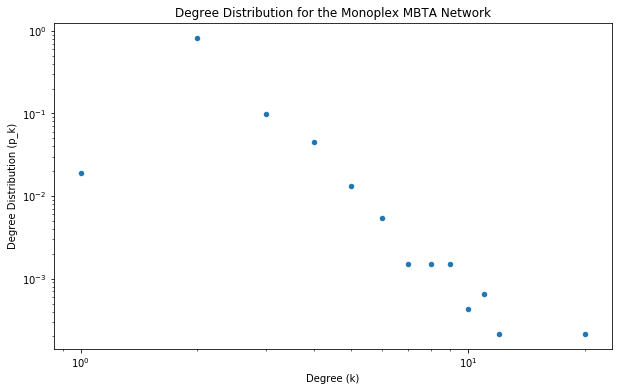

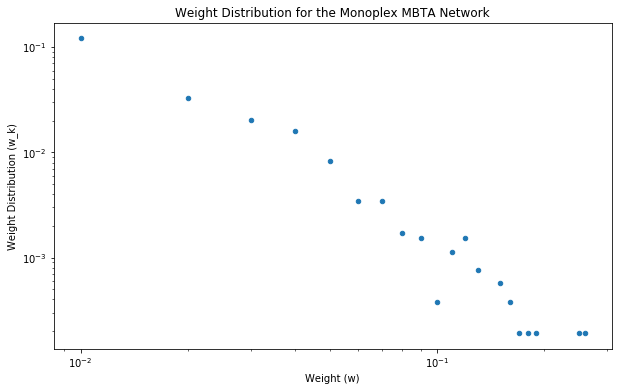

In [12]:
#Full MBTA
n_Full = len(G.nodes())
l_Full = len(G.edges())
C_Full = nx.average_clustering(G)
connectedComponents_Full=len(list(nx.connected_components(G)))

print('|N_Monoplex|={0}'.format(n_Full))
print('|L_Monoplex|={0}'.format(l_Full))
print('|C_Full|={0}'.format(C_Full))
print('|Connected Components|={0}'.format(connectedComponents_Full))

#Develop degree distribution plot and plot on log-log scale
degDistFull=pd.DataFrame(pd.Series(list(dict(G.degree()).values())).value_counts()).reset_index().rename(columns = {'index':'k',0:'p_k'})
degDistFull.p_k=degDistFull.p_k/degDistFull.p_k.sum()
degDistFull.plot(x='k',y='p_k',kind='scatter',loglog=True,figsize=(10,6))
fit = powerlaw.Fit(degDistFull.p_k)
print('degree gamma: {0}'.format(fit.alpha))
plt.xlabel('Degree (k)')
plt.ylabel('Degree Distribution (p_k)')
plt.title('Degree Distribution for the Monoplex MBTA Network')

wDistFull=pd.DataFrame(pd.Series([round(G.get_edge_data(e[0],e[1])['Distance'],2) for e in G.edges(data=True)]).value_counts()).reset_index().rename(columns = {'index':'w',0:'p_w'})
wDistFull.p_w=wDistFull.p_w/wDistFull.p_w.sum()
fit = powerlaw.Fit(wDistFull.p_w.loc[wDistFull.w!=0.0])
#fit.plot_pdf(color = 'g', linestyle='--', label = 'power law fit')
print('weight gamma: {0}'.format(fit.alpha))
wDistFull.loc[wDistFull.w!=0.0].plot(x='w',y='p_w',kind='scatter',loglog=True,figsize=(10,6))
plt.xlabel('Weight (w)')
plt.ylabel('Weight Distribution (w_k)')
plt.title('Weight Distribution for the Monoplex MBTA Network')

|N_Monoplex|=131
|L_Monoplex|=133
|C_Full|=0.017811704834605594
|Connected Components|=1


Calculating best minimal value for power law fit
C:\Users\Owner\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


degree gamma: 1.7876661030723326
weight gamma: 1.5374120489964767


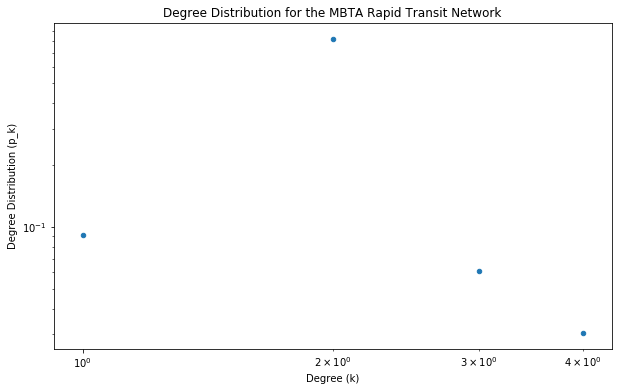

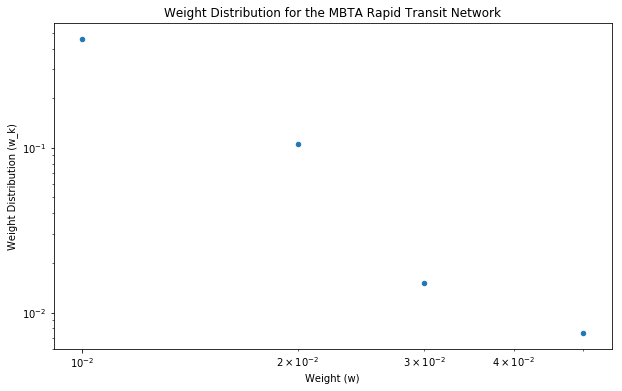

In [159]:
#Subway Network Characteristics
n_Subway = len(subwayGraph.nodes())
l_Subway = len(subwayGraph.edges())
C_Subway = nx.average_clustering(subwayGraph)
connectedComponents_Subway=len(list(nx.connected_components(subwayGraph)))

print('|N_Subway|={0}'.format(n_Subway))
print('|L_Subway|={0}'.format(l_Subway))
print('|C_Subway|={0}'.format(C_Subway))
print('|Connected Components|={0}'.format(connectedComponents_Subway))

#Develop degree distribution plot and plot on log-log scale
degDistSubway=pd.DataFrame(pd.Series(list(dict(subwayGraph.degree()).values())).value_counts()).reset_index().rename(columns = {'index':'k',0:'p_k'})
degDistSubway.p_k=degDistSubway.p_k/degDistSubway.p_k.sum()
degDistSubway.plot(x='k',y='p_k',kind='scatter',loglog=True,figsize=(10,6))
fit = powerlaw.Fit(degDistSubway.p_k)
print('degree gamma: {0}'.format(fit.alpha))
plt.xlabel('Degree (k)')
plt.ylabel('Degree Distribution (p_k)')
plt.title('Degree Distribution for the MBTA Rapid Transit Network')

wDistSubway=pd.DataFrame(pd.Series([round(subwayGraph.get_edge_data(e[0],e[1])['Distance'],2) for e in subwayGraph.edges(data=True)]).value_counts()).reset_index().rename(columns = {'index':'w',0:'p_w'})
wDistSubway.p_w=wDistSubway.p_w/wDistSubway.p_w.sum()
fit = powerlaw.Fit(wDistSubway.p_w.loc[wDistSubway.w!=0.0])
#fit.plot_pdf(color = 'g', linestyle='--', label = 'power law fit')
print('weight gamma: {0}'.format(fit.alpha))
wDistSubway.loc[wDistSubway.w!=0.0].plot(x='w',y='p_w',kind='scatter',loglog=True,figsize=(10,6))
plt.xlabel('Weight (w)')
plt.ylabel('Weight Distribution (w_k)')
plt.title('Weight Distribution for the MBTA Rapid Transit Network')

|N_Bus|=4395
|L_Bus|=4974
|C_Bus|=0.026062837725154508
|Connected Components_Bus|=1


Calculating best minimal value for power law fit
C:\Users\Owner\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


degree gamma: 1.521457580412151
weight gamma: 1.4926208148857811


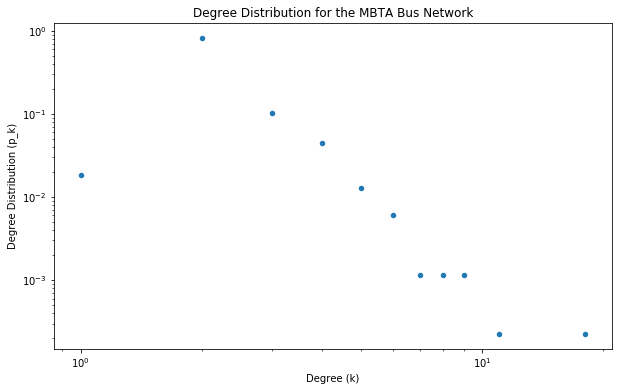

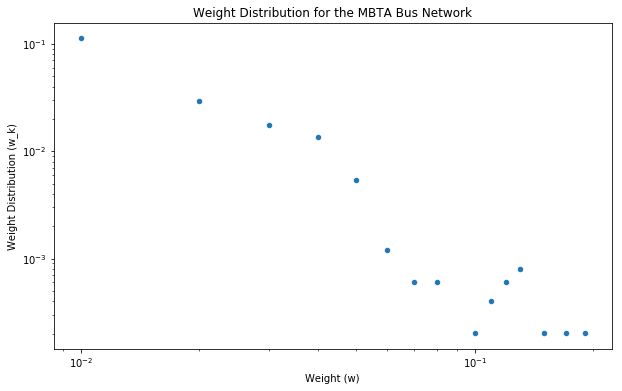

In [160]:
#Bus Network Characteristics
n_Bus = len(busGraph.nodes())
l_Bus = len(busGraph.edges())
C_Bus = nx.average_clustering(busGraph)
connectedComponents_Bus=len(list(nx.connected_components(busGraph)))

print('|N_Bus|={0}'.format(n_Bus))
print('|L_Bus|={0}'.format(l_Bus))
print('|C_Bus|={0}'.format(C_Bus))
print('|Connected Components_Bus|={0}'.format(connectedComponents_Bus))

#Develop degree distribution plot and plot on log-log scale
degDistBus=pd.DataFrame(pd.Series(list(dict(busGraph.degree()).values())).value_counts()).reset_index().rename(columns = {'index':'k',0:'p_k'})
degDistBus.p_k=degDistBus.p_k/degDistBus.p_k.sum()
degDistBus.plot(x='k',y='p_k',kind='scatter',loglog=True,figsize=(10,6))
fit = powerlaw.Fit(degDistBus.p_k)
print('degree gamma: {0}'.format(fit.alpha))
plt.xlabel('Degree (k)')
plt.ylabel('Degree Distribution (p_k)')
plt.title('Degree Distribution for the MBTA Bus Network')

wDistBus=pd.DataFrame(pd.Series([round(busGraph.get_edge_data(e[0],e[1])['Distance'],2) for e in busGraph.edges(data=True)]).value_counts()).reset_index().rename(columns = {'index':'w',0:'p_w'})
wDistBus.p_w=wDistBus.p_w/wDistBus.p_w.sum()
fit = powerlaw.Fit(wDistBus.p_w.loc[wDistBus.w!=0.0])
#fit.plot_pdf(color = 'g', linestyle='--', label = 'power law fit')
print('weight gamma: {0}'.format(fit.alpha))
wDistBus.loc[wDistBus.w!=0.0].plot(x='w',y='p_w',kind='scatter',loglog=True,figsize=(10,6))
plt.xlabel('Weight (w)')
plt.ylabel('Weight Distribution (w_k)')
plt.title('Weight Distribution for the MBTA Bus Network')

|N_CR|=140
|L_CR|=144
|C_CR|=0.029761904761904757
|Connected Components_CR|=2


Calculating best minimal value for power law fit
C:\Users\Owner\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


degree gamma: 2.0190386397569484
weight gamma: 10.056887849262868


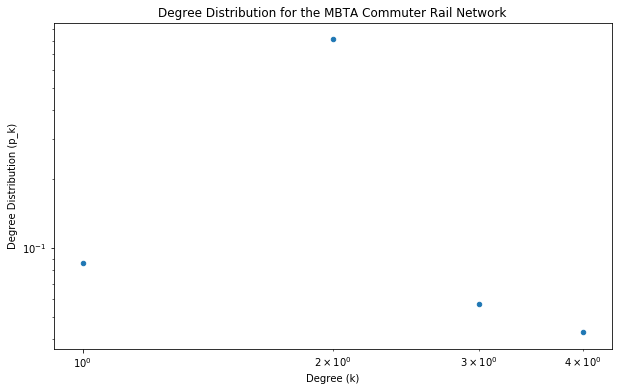

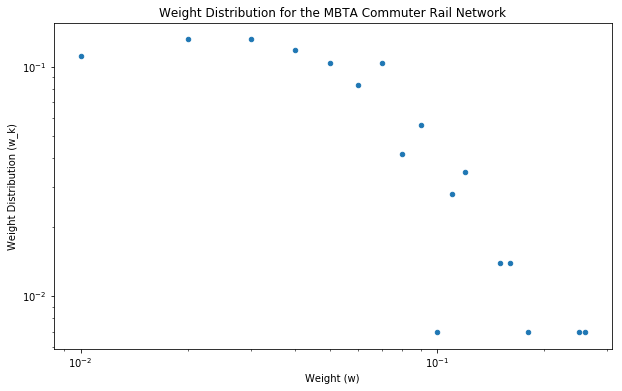

In [163]:
#Commuter Rail Network Characteristics
n_CR = len(crGraph.nodes())
l_CR = len(crGraph.edges())
C_CR = nx.average_clustering(crGraph)
connectedComponents_CR=len(list(nx.connected_components(crGraph)))

print('|N_CR|={0}'.format(n_CR))
print('|L_CR|={0}'.format(l_CR))
print('|C_CR|={0}'.format(C_CR))
print('|Connected Components_CR|={0}'.format(connectedComponents_CR))

#Develop degree distribution plot and plot on log-log scale
degDistCR=pd.DataFrame(pd.Series(list(dict(crGraph.degree()).values())).value_counts()).reset_index().rename(columns = {'index':'k',0:'p_k'})
degDistCR.p_k=degDistCR.p_k/degDistCR.p_k.sum()
degDistCR.plot(x='k',y='p_k',kind='scatter',loglog=True,figsize=(10,6))
fit = powerlaw.Fit(degDistCR.p_k)
print('degree gamma: {0}'.format(fit.alpha))
plt.xlabel('Degree (k)')
plt.ylabel('Degree Distribution (p_k)')
plt.title('Degree Distribution for the MBTA Commuter Rail Network')

wDistCR=pd.DataFrame(pd.Series([round(crGraph.get_edge_data(e[0],e[1])['Distance'],2) for e in crGraph.edges(data=True)]).value_counts()).reset_index().rename(columns = {'index':'w',0:'p_w'})
wDistCR.p_w=wDistCR.p_w/wDistCR.p_w.sum()
fit = powerlaw.Fit(wDistCR.p_w.loc[wDistCR.w!=0.0])
#fit.plot_pdf(color = 'g', linestyle='--', label = 'power law fit')
print('weight gamma: {0}'.format(fit.alpha))
wDistCR.loc[wDistCR.w!=0.0].plot(x='w',y='p_w',kind='scatter',loglog=True,figsize=(10,6))
plt.xlabel('Weight (w)')
plt.ylabel('Weight Distribution (w_k)')
plt.title('Weight Distribution for the MBTA Commuter Rail Network')

In [187]:
subgraph=nx.subgraph(G,list(G.nodes())[:100])
connected_subgraph=list(nx.connected_component_subgraphs(subgraph))[0]

(-71.030395, 42.374262)

In [203]:
def nullModel(graph,weight):
    '''
    Develops null models using modified degree randomization. Our modifications currently only have a distance threshold of 0.5
    '''
    graphCopy=graph.copy()
    degrees=dict(graphCopy.degree())
    edges=list(graphCopy.edges())
    gSize=len(edges)
    edgeIndices=list(range(len(edges)))
    #create an upper bound of E.
    for t in range(gSize):
        edgesToRemove=chooseEdge(edges,edgeIndices)
        if weight==None:
            while edgesToRemove[0][0]==edgesToRemove[1][1] or edgesToRemove[0][1]==edgesToRemove[1][1] or edgesToRemove[0][1]==edgesToRemove[1][1] or edgesToRemove[0][1]==edgesToRemove[1][0]: 
                edgesToRemove=chooseEdge(edges,edgeIndices)
        else:
            #read as while none of the edges in a swap are the same and the swaps will not results in links longer than 0.05
            while (edgesToRemove[0][0]==edgesToRemove[1][1] or edgesToRemove[0][1]==edgesToRemove[1][1] or edgesToRemove[0][1]==edgesToRemove[1][0] or edgesToRemove[0][1]==edgesToRemove[1][0]) or (euclidean_distance(graph.nodes()[edgesToRemove[0][0]]['loc'],graph.nodes()[edgesToRemove[1][1]]['loc'])>=0.05 or euclidean_distance(graph.nodes()[edgesToRemove[0][1]]['loc'],graph.nodes()[edgesToRemove[1][0]]['loc'])>=0.05):
                if 'Bus' in graph.nodes()[edgesToRemove[0][0]] and ''
                edgesToRemove=chooseEdge(edges,edgeIndices)
        graphCopy.remove_edges_from(edgesToRemove) 
        edges.pop(edges.index(edgesToRemove[0]))
        edges.pop(edges.index(edgesToRemove[1]))
        
        #do swaps
        swaps=[(edgesToRemove[0][0],edgesToRemove[1][1]),(edgesToRemove[0][1],edgesToRemove[1][0])] 
        graphCopy.add_edges_from(swaps)
        
        #recompute edges and indices
        edges=list(graphCopy.edges())
        edgeIndices=list(range(len(edges)))
    return graphCopy
def chooseEdge(e,e_i):
    '''
    A helper function to the nullModel function. 
    Helps choose edge by randomly getting the index of two edges and makes sure
    that the indices are not equal.'''
    edgeIndex1=np.random.choice(e_i)
    edgeIndex2=np.random.choice(e_i)
    while edgeIndex1==edgeIndex2:
        edgeIndex2=np.random.choice(e_i)
    return [e[edgeIndex1],e[edgeIndex2]]

null=nullModel(G,'Distance')
print(len(list(nx.connected_components(null))))


10
